# ICAMP Model (Merton, 1973) #

### Adding a Hedge Portfolio to the CAPM model ###

In [377]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from arch import arch_model

# Pretty Notation
from IPython.display import display, Math

In [378]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [379]:
# Import Data
ticker = 'WMT'

# Stock Data (Adjust Ticker)
df_stock = pd.read_csv(rf"..\stocks\{ticker}.csv")
df_stock = df_stock.set_index('Date')
df_stock.index = pd.to_datetime(df_stock.index)

# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500
sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index, dayfirst=True)

# Get the important data for the Zero Beta Portfolio
zero_beta = pd.read_csv(r"..\additional_data\zero_beta.csv")
zero_beta = zero_beta.set_index('Date')
zero_beta.index = pd.to_datetime(zero_beta.index)

In [380]:
# Create the DataFrame
data = pd.DataFrame()

# Create the Columns
data['stock_returns'] = df_stock['Adjusted_close'].pct_change(1)
data['risk_free_rate'] = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
data['benchmark_returns'] = sp500['sp_500'].pct_change(1)
data['zero_beta_returns'] = zero_beta

# Create the Excess Returns
data['stock_excess_returns'] = data['stock_returns'] - data['risk_free_rate']
data['benchmark_excess_returns'] = data['benchmark_returns'] - data['risk_free_rate']
data['hedge_port_excess_returns'] = data['zero_beta_returns'] - data['risk_free_rate']

# Multiply by 100
data = data.mul(100)

data.dropna(inplace = True)
data

,stock_returns,risk_free_rate,benchmark_returns,zero_beta_returns,stock_excess_returns,benchmark_excess_returns,hedge_port_excess_returns
Date,,,,,,,
2015-02-24,-0.035461,0.005474,0.275874,0.513512,-0.040935,0.270400,0.508038
2015-02-25,-1.182452,0.005392,-0.076578,0.885601,-1.187844,-0.081970,0.880209
2015-02-26,0.275216,0.005583,-0.147597,0.528835,0.269634,-0.153180,0.523252
2015-02-27,0.155134,0.005501,-0.295631,-0.882582,0.149633,-0.301132,-0.888083
2015-03-02,0.035744,0.005719,0.612497,0.799628,0.030025,0.606778,0.793909
...,...,...,...,...,...,...,...
2024-10-22,1.497339,0.011429,-0.047489,0.591383,1.485910,-0.058918,0.579954
2024-10-23,1.524019,0.011536,-0.919128,0.197535,1.512483,-0.930663,0.186000
2024-10-24,-0.276210,0.011456,0.214578,-0.309028,-0.287666,0.203123,-0.320483


In [381]:
# Check Correlations Matrix

data[['stock_excess_returns', 'benchmark_excess_returns', 'hedge_port_excess_returns']].corr()

,stock_excess_returns,benchmark_excess_returns,hedge_port_excess_returns
stock_excess_returns,1.000000,0.430728,0.223148
benchmark_excess_returns,0.430728,1.000000,0.014103
hedge_port_excess_returns,0.223148,0.014103,1.000000


In [382]:
# Calculate the ICAPM with the whole time stamp

y = data['stock_excess_returns']

x = data[['benchmark_excess_returns', 'hedge_port_excess_returns']]
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                             WLS Regression Results                             
Dep. Variable:     stock_excess_returns   R-squared:                       0.222
Model:                              WLS   Adj. R-squared:                  0.221
Method:                   Least Squares   F-statistic:                     344.6
Date:                  Fri, 28 Mar 2025   Prob (F-statistic):          2.07e-132
Time:                          23:30:08   Log-Likelihood:                -3908.9
No. Observations:                  2420   AIC:                             7824.
Df Residuals:                      2417   BIC:                             7841.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

In [383]:
# Set rolling window size
window = 252
weights = window * wexp(window, window/2)

# Lists to store rolling coefficients
betas = []
index = []
lower_bounds = []
upper_bounds = []

# Rolling regression
for i in range(window, len(data)):
    Y_window = y.iloc[i - window:i]
    X_window = x.iloc[i - window:i]
    
    X_window = sm.add_constant(X_window)

    # Fit WLS model
    model = sm.WLS(
        Y_window, 
        X_window, 
        missing='drop', 
        weights=weights,
    ).fit()

    # Store coefficients (const, X1, X2)
    betas.append(model.params.values)
    index.append(data.index[i])  # Use the last date of the window

    # Store lower and upper bounds of 95% confidence intervals
    ci = model.conf_int(alpha=0.05)  # 95% CI
    lower_bounds.append(ci.iloc[:, 0].values)  # First column: lower bound
    upper_bounds.append(ci.iloc[:, 1].values)  # Second column: upper bound


In [384]:
# Convert list of coefficients to DataFrame
betas_df = pd.DataFrame(betas, columns=x.columns, index=index)

betas_df

,const,benchmark_excess_returns,hedge_port_excess_returns
2016-02-26,-0.028098,0.644124,0.444151
2016-02-29,-0.042359,0.647631,0.463592
2016-03-01,-0.038419,0.646974,0.469148
2016-03-02,-0.045666,0.636892,0.481844
2016-03-03,-0.049773,0.637117,0.488535
...,...,...,...
2024-10-22,0.116783,0.270078,0.389300
2024-10-23,0.125056,0.266662,0.399354
2024-10-24,0.139959,0.244506,0.401966
2024-10-25,0.134803,0.244942,0.404553


In [385]:
# Lower bounds DataFrame
lower_df = pd.DataFrame(lower_bounds, columns=[f'{col}_lower' for col in x.columns], index=index)

lower_df

,const_lower,benchmark_excess_returns_lower,hedge_port_excess_returns_lower
2016-02-26,-0.178506,0.509024,0.214181
2016-02-29,-0.193566,0.511353,0.232139
2016-03-01,-0.189020,0.511104,0.237680
2016-03-02,-0.195847,0.502620,0.251672
2016-03-03,-0.199453,0.502866,0.258685
...,...,...,...
2024-10-22,-0.026043,0.093664,0.167105
2024-10-23,-0.018083,0.089405,0.176737
2024-10-24,-0.003652,0.066798,0.177914
2024-10-25,-0.008234,0.067382,0.181058


In [386]:
# Upper bounds DataFrame
upper_df = pd.DataFrame(upper_bounds, columns=[f'{col}_upper' for col in x.columns], index=index)

upper_df

,const_upper,benchmark_excess_returns_upper,hedge_port_excess_returns_upper
2016-02-26,0.122311,0.779225,0.674121
2016-02-29,0.108849,0.783909,0.695045
2016-03-01,0.112182,0.782844,0.700617
2016-03-02,0.104515,0.771163,0.712015
2016-03-03,0.099906,0.771368,0.718386
...,...,...,...
2024-10-22,0.259609,0.446493,0.611494
2024-10-23,0.268195,0.443919,0.621971
2024-10-24,0.283571,0.422214,0.626017
2024-10-25,0.277840,0.422503,0.628049


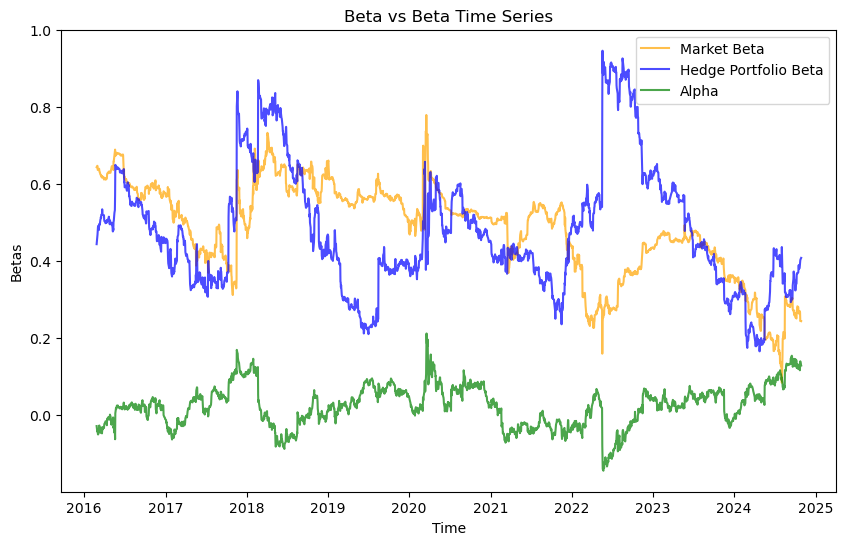

In [387]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_df['benchmark_excess_returns'], label='Market Beta', color='orange', alpha=0.7)
plt.plot(betas_df['hedge_port_excess_returns'], label='Hedge Portfolio Beta', color='blue', alpha=0.7)
plt.plot(betas_df['const'], label='Alpha', color='green', alpha=0.7)

# Config
plt.title('Beta vs Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

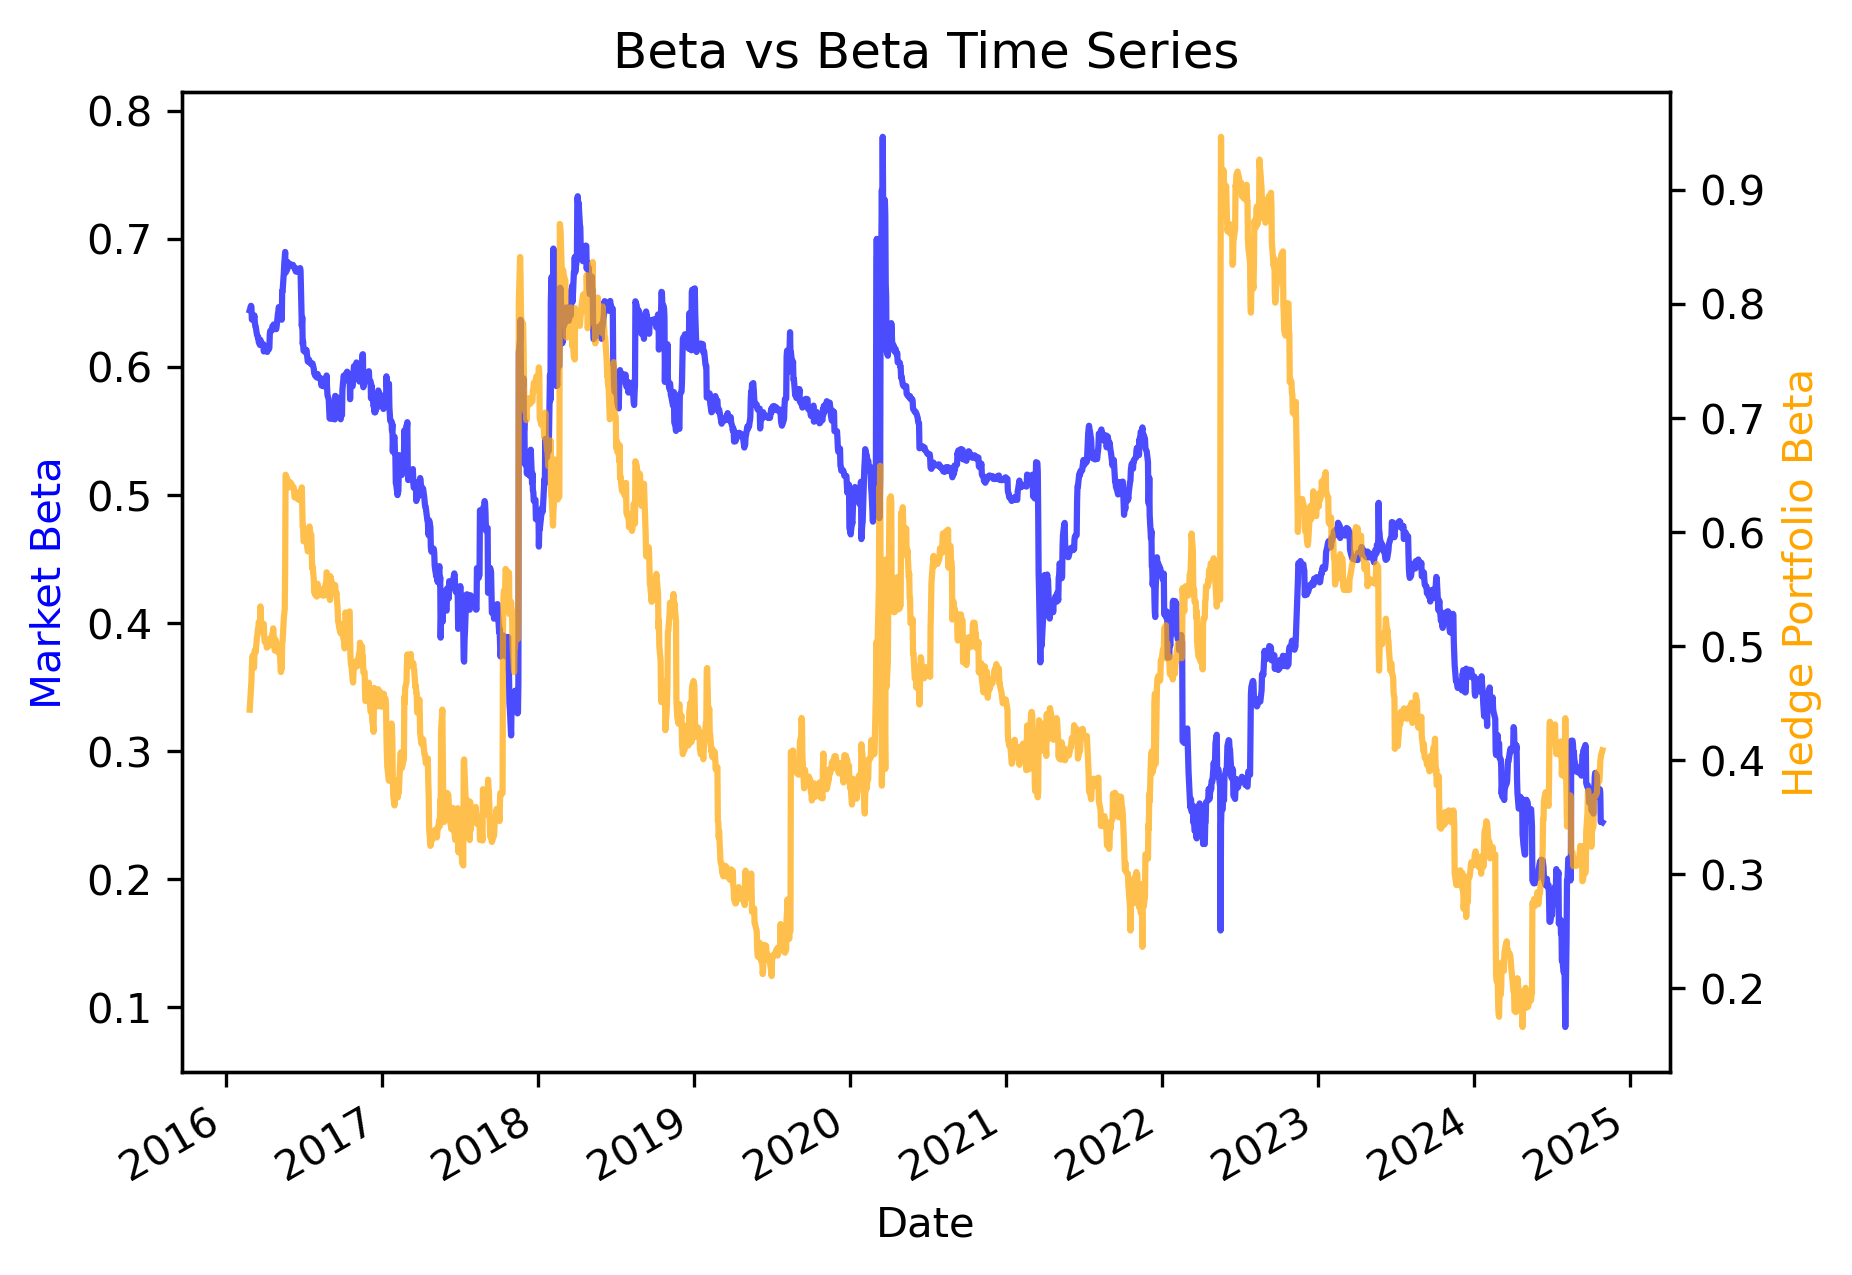

In [388]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Unemployment Rate Plot
betas_df['benchmark_excess_returns'].plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Beta', 
    color='blue'
    )

# Unemployment Mentions Plot
ax2 = ax1.twinx()

betas_df['hedge_port_excess_returns'].plot(color = 'orange', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Hedge Portfolio Beta', 
    color='orange'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

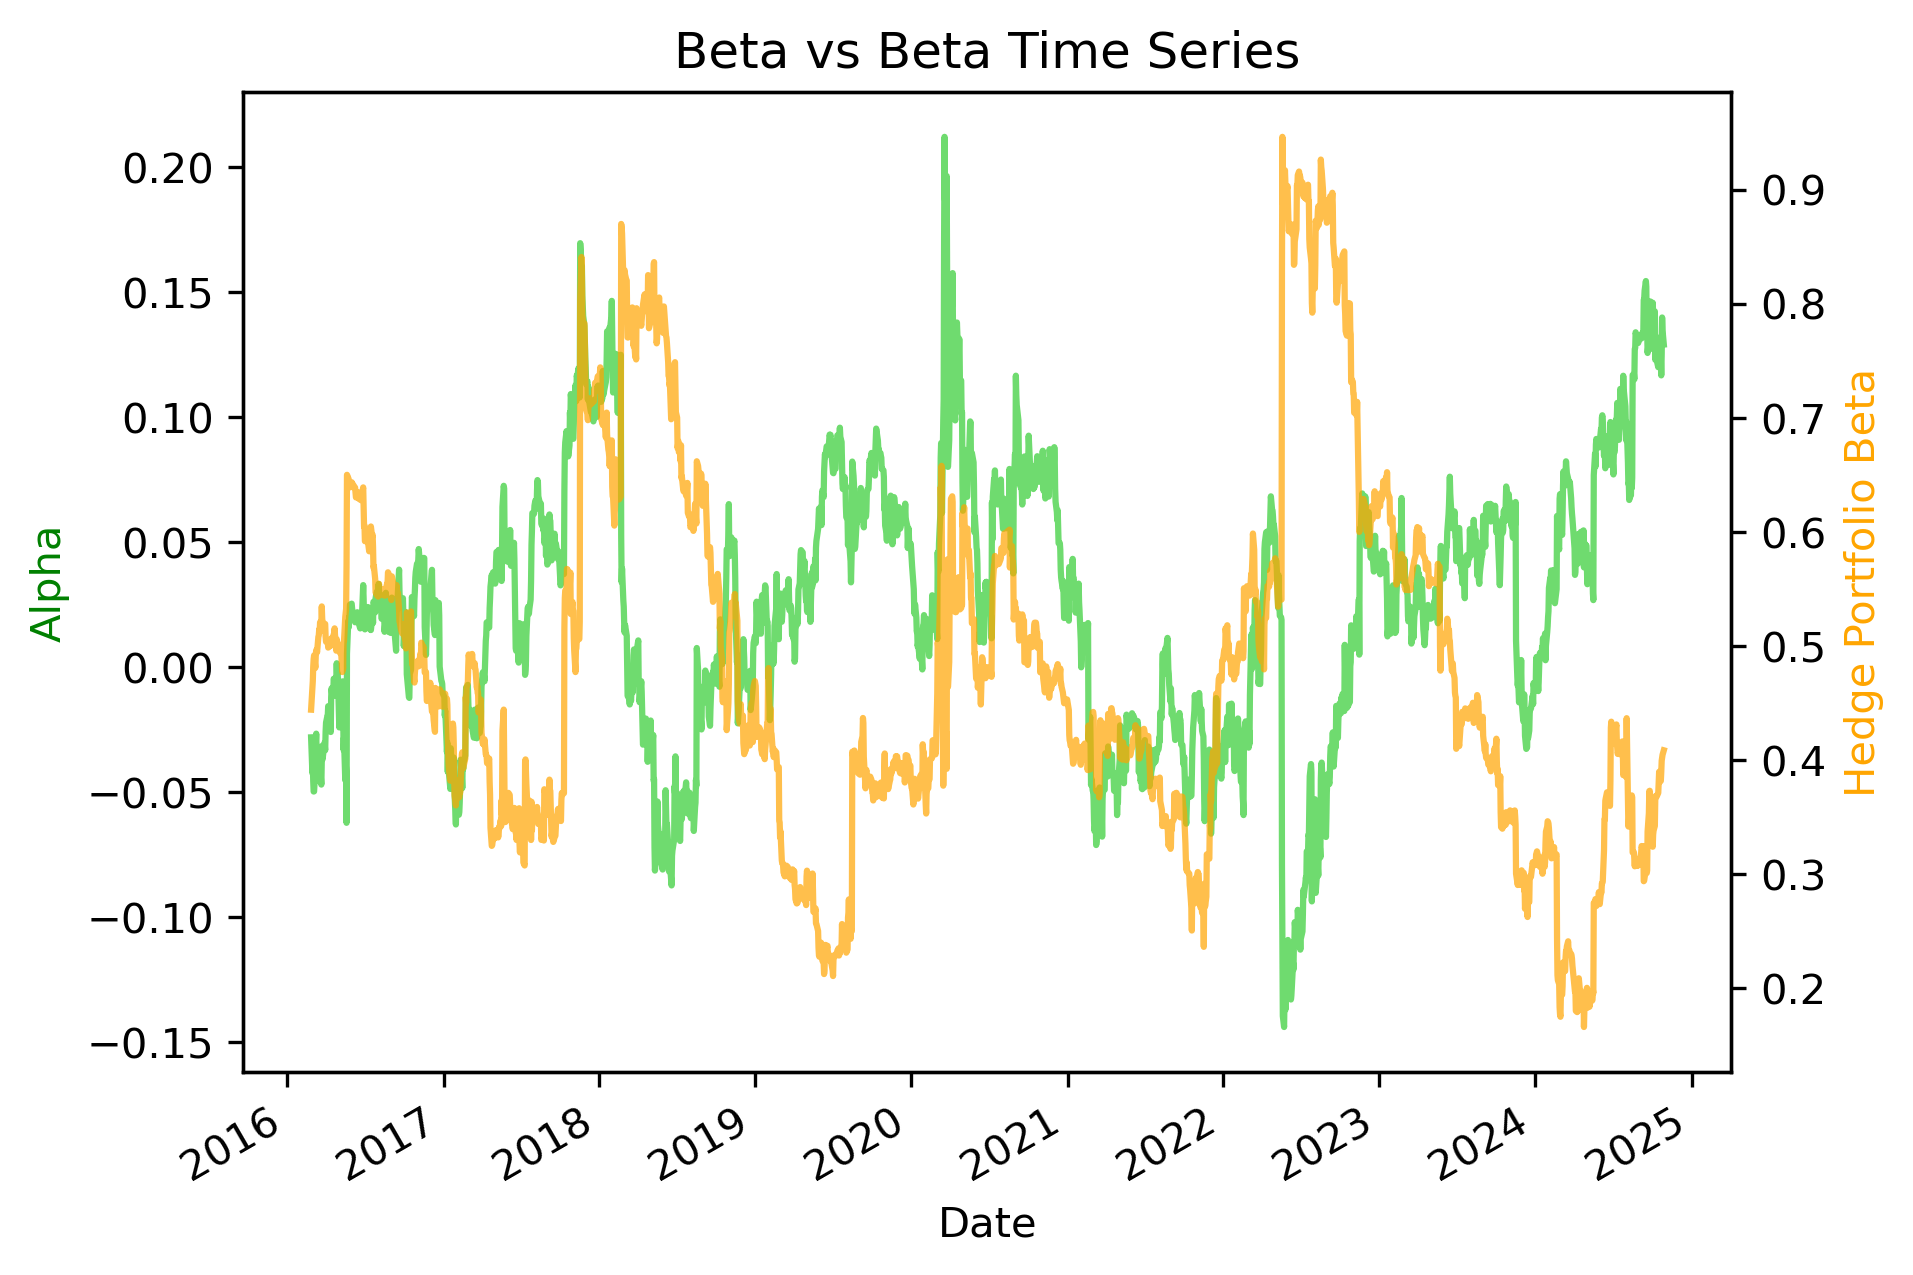

In [389]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Unemployment Rate Plot
betas_df['const'].plot(color = 'limegreen', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Alpha', 
    color='green'
    )

# Unemployment Mentions Plot
ax2 = ax1.twinx()

betas_df['hedge_port_excess_returns'].plot(color = 'orange', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Hedge Portfolio Beta', 
    color='orange'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

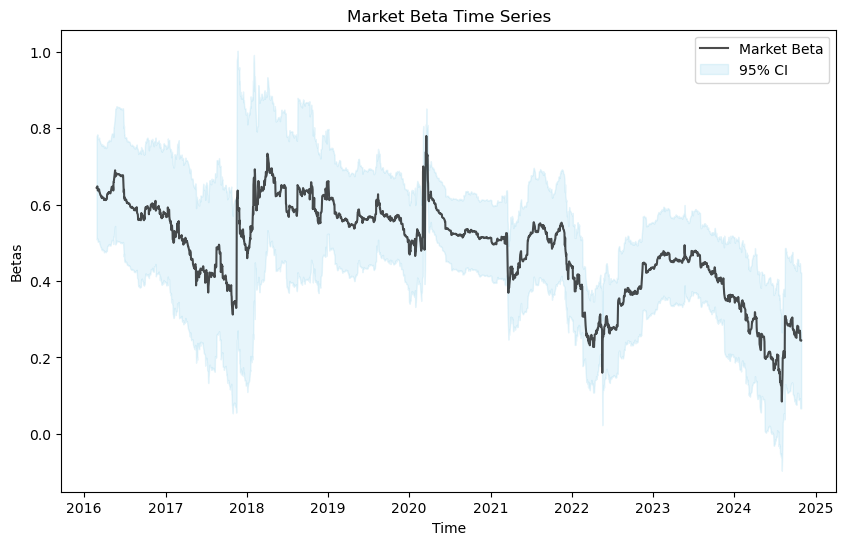

In [390]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_df['benchmark_excess_returns'], label='Market Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['benchmark_excess_returns_lower'], upper_df['benchmark_excess_returns_upper'], color='skyblue', alpha=0.2, label='95% CI')

# Config
plt.title('Market Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

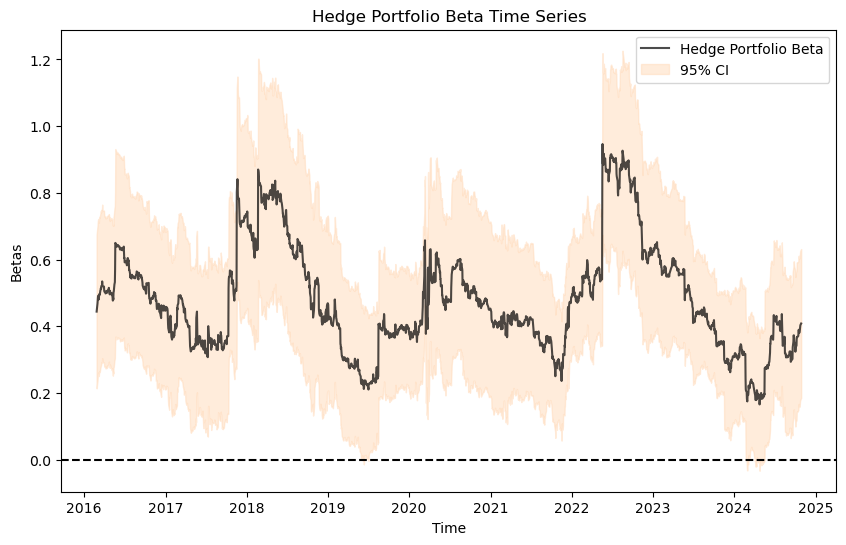

In [391]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_df['hedge_port_excess_returns'], label='Hedge Portfolio Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['hedge_port_excess_returns_lower'], upper_df['hedge_port_excess_returns_upper'], color='peachpuff', alpha=0.5, label='95% CI')
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Hedge Portfolio Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

In [392]:
# We are going to add a new variable to add robustness to our model

# Define Dependent Variable for GARCH Model
benchmark_excess_returns = data["benchmark_excess_returns"]

# Adjust Model GARCH(1,1)
garch_model = arch_model(benchmark_excess_returns, vol="Garch", p=1, q=1)
garch_fit = garch_model.fit(disp="off")

# Get Conditional VOlatility
data["volatility_conditional"] = np.sqrt(garch_fit.conditional_volatility)

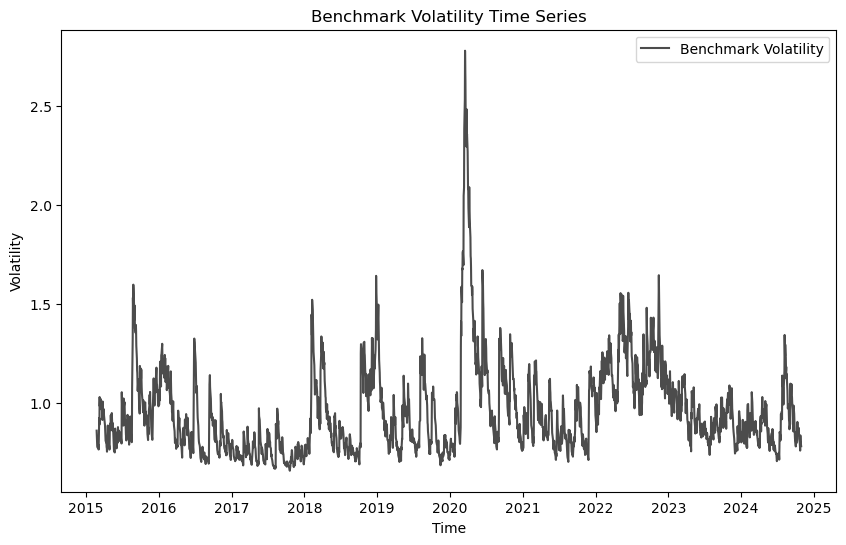

In [393]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(data['volatility_conditional'], label='Benchmark Volatility', color='black', alpha=0.7)

# Config
plt.title('Benchmark Volatility Time Series')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

# Show
plt.show()

In [394]:
# Set a New Linear Regression Specification
y = data["stock_excess_returns"]
x = data[["benchmark_excess_returns", "hedge_port_excess_returns", "volatility_conditional"]]

# Add Constant
x = sm.add_constant(x)

# Adjust Regression
icapm_model = sm.OLS(y, x).fit()
print(icapm_model.summary())

                             OLS Regression Results                             
Dep. Variable:     stock_excess_returns   R-squared:                       0.233
Model:                              OLS   Adj. R-squared:                  0.232
Method:                   Least Squares   F-statistic:                     244.5
Date:                  Fri, 28 Mar 2025   Prob (F-statistic):          1.49e-138
Time:                          23:30:12   Log-Likelihood:                -3814.8
No. Observations:                  2420   AIC:                             7638.
Df Residuals:                      2416   BIC:                             7661.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

Why are the Hedge Portfolio's Returns Negatively Related to the Stock's Returns (in some cases)?

Merton uses the Hedge Portfolio (in this case, a Zero-Beta Portfolio or ZBP) as an instrumental variable to capture the effects of 
certain macroeconomic state variables on the stock's returns. The ZBP is constructed to be practically uncorrelated with the benchmark 
(e.g., the S&P 500), meaning it does not share systematic risk with the market.

When we estimate the beta for the benchmark, it explains the systematic risk that the stock faces. On the other hand, the beta estimated 
for the Hedge Portfolio captures the stock's exposure to non-systematic risk—risks that are not directly tied to the market but rather to 
specific economic or financial factors that might affect the asset differently.

Since the ZBP is designed to be uncorrelated with the market, it tends to move in the opposite direction of the market in response to 
macroeconomic changes. This hedging characteristic means that the stock’s exposure to the non-systematic risks represented by the Hedge 
Portfolio could result in movements in the stock that are opposite to those of the market (in the case of negative returns for the hedge 
portfolio).

If the coefficient in the regression suggests a negative relationship between the stock’s returns and the Hedge Portfolio’s returns, it 
implies that when the non-systematic risks captured by the ZBP negatively affect the hedge portfolio, they might similarly affect the 
stock in the opposite direction but with the same magnitude. Thus, the stock could benefit from those specific macroeconomic factors, even 
when the hedge portfolio is negatively affected.